---
aliases:
- /2022/09/18/Optical-Character-Recognition
date: '2022-09-18'
description: Artikel ini membahas tentang cara sebuah gagasan dan pendekatan sederhana untuk membuat sebuah OCR (Optical Character Recognition) untuk melakukan extraksi text dari sebuah gambar catatan/halaman yang ditulis tangan.
output-file: 2022-09-18-Optical-Character-Recognition.html
title: Optical Character Recognition Untuk Gambar Dengan Tulisan Tangan Menggunakan Tensorflow
image: images/OCR.png
author: "I Made Nusa Yudiskara"
categories:
- jupyter
- code
- classification
- image recognition
- tensorflow
- data cleaning
---

# Optical Character Recognition Untuk Gambar Dengan Tulisan Tangan Menggunakan Tensorflow

### Artikel ini membahas tentang cara sebuah gagasan dan pendekatan sederhana untuk membuat sebuah OCR (Optical Character Recognition) untuk melakukan extraksi text dari sebuah gambar catatan/halaman yang ditulis tangan.

## Apa itu Optical Character Recognition (OCR)?
Optical Character Recognition adalah konversi otomatis teks dalam gambar menjadi kode huruf yang dapat digunakan dalam komputer dan aplikasi pemrosesan teks. Secara sederhana, ini adalah ekstraksi teks dari sebuah catatan/halaman dengan tulisan tangan dengan menggunakan alat seperti stylus, pensil ,pena ,dll.

## Cara Kerja

* **1** :  Buat sebuah classifier digit (0-9) dan huruf (A-Z + a-z) menggunakan arsitektur cnn 
* **2** :  Terapkan segmentasi pada setiap huruf pada kata yang telah ditulis
* **3** :  Klasifikasi setiap segment huruf kemudian dapatkan kata akhir dari gambar tersebut.

In [11]:
# Import Library
import numpy as np
import pandas as pd
from keras.preprocessing.image import ImageDataGenerator
import os
import random 
import cv2
import imutils
import random
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelBinarizer
from keras.utils import np_utils
from keras.models import Sequential
from keras import optimizers
from sklearn.preprocessing import LabelBinarizer
from keras import backend as K
from keras.layers import Dense, Activation, Flatten, Dense,MaxPooling2D, Dropout
from keras.layers import Conv2D, MaxPooling2D, BatchNormalization

Dari data train hanya gunakan gambar (A-Z + a-z) dan 0-9. Kemudian ubah setiap nilai pixel pada gambar menjadi ke bentuk array

In [12]:
dir = "../input/handwritten-characters/Train/"
train_data = []
img_size = 32
non_chars = ["#","$","&","@"]
for i in os.listdir(dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 4000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        train_data.append([img,i])

In [13]:
len(train_data)

140000

Lakukan hal yang sama pada data validation

In [14]:
val_dir = "../input/handwritten-characters/Validation/"
val_data = []
img_size = 32
for i in os.listdir(val_dir):
    if i in non_chars:
        continue
    count = 0
    sub_directory = os.path.join(val_dir,i)
    for j in os.listdir(sub_directory):
        count+=1
        if count > 1000:
            break
        img = cv2.imread(os.path.join(sub_directory,j),0)
        img = cv2.resize(img,(img_size,img_size))
        val_data.append([img,i])

In [15]:
len(val_data)

15209

In [16]:
# Shuffle atau acak setiap data yang ada pada train dan validation
random.shuffle(train_data)
random.shuffle(val_data)

In [17]:
# Pisahkan nilai fitur dan label pada data train menjadi train_X untuk fitur dan train_Y untuk label
train_X = []
train_Y = []
for features,label in train_data:
    train_X.append(features)
    train_Y.append(label)

In [18]:
# Pisahkan nilai fitur dan label pada data validation menjadi val_X untuk fitur dan val_Y untuk label
val_X = []
val_Y = []
for features,label in val_data:
    val_X.append(features)
    val_Y.append(label)

Transformasi label ke bentuk biner dengan menggunakan `LabelBinarizer()` fungsi  untuk mempercepat proses komputasi
Pada kasus ini terdapat 62 :
* A = [1, 0, 0, ... ,0]
* B = [0, 1, 0, ... ,0]
* C = [0, 0, 1, ... ,0]
* dst

In [19]:
LB = LabelBinarizer()
train_Y = LB.fit_transform(train_Y)
val_Y = LB.fit_transform(val_Y)

In [20]:
train_X = np.array(train_X)/255.0 # Ubah tipe data train_X dari list menjadi numpy.array dan ubah rentang nilai pixel dari 0-255 menjadi 0-1
train_X = train_X.reshape(-1,32,32,1) # Ubah dimensi numpy.array dari (jumlah array, 32, 32) menjadi (jumlah array, 32, 32, 1)
train_Y = np.array(train_Y) # Ubah tipe data train_Y dari list menjadi numpy.array

In [21]:
val_X = np.array(val_X)/255.0 # Ubah tipe data val_X dari list menjadi numpy.array dan ubah rentang nilai pixel dari 0-255 menjadi 0-1
val_X = val_X.reshape(-1,32,32,1) # Ubah dimensi numpy.array dari (jumlah array, 32, 32) menjadi (jumlah array, 32, 32, 1)
val_Y = np.array(val_Y) # Ubah tipe data val_Y dari list menjadi numpy.array

In [22]:
print(train_X.shape,val_X.shape) # Tampilkan hasil reshape

(140000, 32, 32, 1) (15209, 32, 32, 1)


In [23]:
print(train_Y.shape,val_Y.shape) # Tampilkan hasil reshape

(140000, 35) (15209, 35)


Bangun model arsitektur neural network yang dibuat. Pada kasus ini, karena kita menghadapi kasus image recognition maka saya akan menggunakan model sequential menggunakan CNN(Convolutional Neural Network)

In [24]:
model = Sequential()

model.add(Conv2D(32, (3, 3), padding = "same", activation='relu', input_shape=(32,32,1)))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Dropout(0.25))
 
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(35, activation='softmax'))

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 5, 5, 128)         73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 2, 2, 128)         0         
_________________________________________________________________
dropout (Dropout)            (None, 2, 2, 128)         0

In [26]:
model.compile(loss='categorical_crossentropy', optimizer="adam",metrics=['accuracy'])

In [27]:
history = model.fit(train_X,train_Y, epochs=50, batch_size=32, validation_data = (val_X, val_Y),  verbose=1)

Epoch 1/50
4375/4375 [==============================] - 13s 3ms/step - loss: 0.6208 - accuracy: 0.8020 - val_loss: 0.2941 - val_accuracy: 0.9089
Epoch 2/50
4375/4375 [==============================] - 13s 3ms/step - loss: 0.3500 - accuracy: 0.8819 - val_loss: 0.3439 - val_accuracy: 0.8565
Epoch 3/50
4375/4375 [==============================] - 12s 3ms/step - loss: 0.3044 - accuracy: 0.8957 - val_loss: 0.2723 - val_accuracy: 0.9011
Epoch 4/50
4375/4375 [==============================] - 12s 3ms/step - loss: 0.2779 - accuracy: 0.9039 - val_loss: 0.2713 - val_accuracy: 0.8966
Epoch 5/50
4375/4375 [==============================] - 13s 3ms/step - loss: 0.2639 - accuracy: 0.9083 - val_loss: 0.2434 - val_accuracy: 0.9143
Epoch 6/50
4375/4375 [==============================] - 12s 3ms/step - loss: 0.2493 - accuracy: 0.9123 - val_loss: 0.2556 - val_accuracy: 0.8985
Epoch 7/50
4375/4375 [==============================] - 13s 3ms/step - loss: 0.2389 - accuracy: 0.9159 - val_loss: 0.2454 - val_ac

Kode dibawah ini akan menampilkan plot tingkat akurasi model pada setiap epoch ketika diuji menggunakan data Train(garis biru) dan Validation(Garis Kuning)

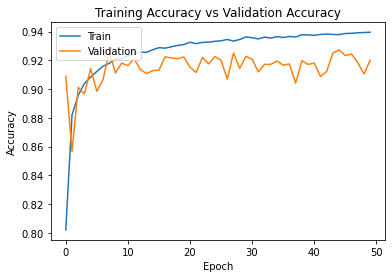

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training Accuracy vs Validation Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

Kode dibawah ini akan menampilkan plot Loss model pada setiap epoch ketika diuji menggunakan data Train(garis biru) dan Validation(Garis Kuning)

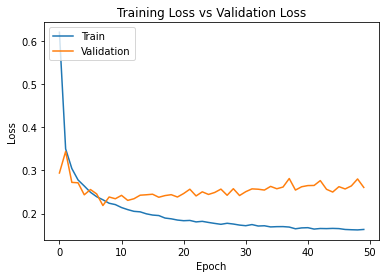

In [29]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training Loss vs Validation Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Recognition and Post-Processing 
1. Fungsi sort contuour berfungsi untuk mendapatkan urutan yang tepat untuk setiap karakter atau huruf pada sebuah gambar. Pada kasus ini fungsi ini akan mencoba meng-extrack setiap huruf yang ada pada gambar sesuai urutan dari kiri ke kanan.
2. Fungsi get letter adalah mengumpulkan setiap contour huruf pada pada gambar dan melakukan prediksi dengan menggunakan model yang telah dibangun untuk setiap huruf sehingga membentuk sebuah kata 

In [30]:
def sort_contours(cnts, method="left-to-right"):
    reverse = False
    i = 0
    if method == "right-to-left" or method == "bottom-to-top":
        reverse = True
    if method == "top-to-bottom" or method == "bottom-to-top":
        i = 1
    boundingBoxes = [cv2.boundingRect(c) for c in cnts]
    (cnts, boundingBoxes) = zip(*sorted(zip(cnts, boundingBoxes),
    key=lambda b:b[1][i], reverse=reverse))
    return (cnts, boundingBoxes)

In [31]:
def get_letters(img):
    letters = []
    image = cv2.imread(img)
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    ret,thresh1 = cv2.threshold(gray ,127,255,cv2.THRESH_BINARY_INV)
    dilated = cv2.dilate(thresh1, None, iterations=2)

    cnts = cv2.findContours(dilated.copy(), cv2.RETR_EXTERNAL,cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    cnts = sort_contours(cnts, method="left-to-right")[0]
    # Untuk setiap contour lakukan prediksi huruf menggunakan model tensorflow
    for c in cnts:
        if cv2.contourArea(c) > 10:
            (x, y, w, h) = cv2.boundingRect(c)
            cv2.rectangle(image, (x, y), (x + w, y + h), (0, 255, 0), 2)
        roi = gray[y:y + h, x:x + w]
        thresh = cv2.threshold(roi, 0, 255,cv2.THRESH_BINARY_INV | cv2.THRESH_OTSU)[1]
        thresh = cv2.resize(thresh, (32, 32), interpolation = cv2.INTER_CUBIC)
        thresh = thresh.astype("float32") / 255.0
        thresh = np.expand_dims(thresh, axis=-1)
        thresh = thresh.reshape(1,32,32,1)
        ypred = model.predict(thresh)
        ypred = LB.inverse_transform(ypred)
        [x] = ypred
        letters.append(x)
    return letters, image


In [32]:
# Fungsi ini dibuat untuk menggabungkan semua list prediksi huruf menjadi sebuah kata
def get_word(letter):
    word = "".join(letter)
    return word

R0ML1N


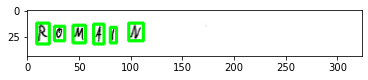

In [57]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00020.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

IAFFFLX


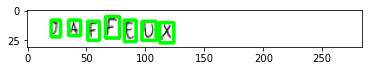

In [35]:
letter,image = get_letters("../input/handwriting-recognition/train_v2/train/TRAIN_00030.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

RUPP


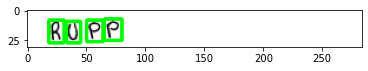

In [36]:
letter,image = get_letters("../input/handwriting-recognition/validation_v2/validation/VALIDATION_0005.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

VFLENTJNE


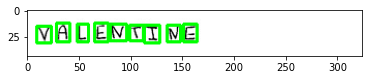

In [37]:
letter,image = get_letters("../input/handwriting-recognition/test_v2/test/TEST_0007.jpg")
word = get_word(letter)
print(word)
plt.imshow(image)

## Kekurangan
1. Pada tahap recognition sangat tergantung kepada contour detection dari library opencv, jadi jika opencv tidak dapat menemukan contour huruf maka metode ini akan gagal.
2. Ada banyak variasi huruf untuk setiap tulisan huruf, sehingga masih banyak contoh yang diperlukan untuk melakukan training pada model ini.
3. Model ini tidak akan berhasil jika digunakan pada huruf jalan atau sambung.

## Kesimpulan 
Pada artikel ini kita telah membahas bagaimana pendekatan character segmentation dan classification dapat digunakan untuk membuat sebuah OCR (Optical Character Recognition) untuk tulisan tangan. Untuk meningkatkan performa model ini, lebih banyak dataset diperlukan untuk pada proses training untuk mendapatkan performa yang lebih baik. 

## Referensi
1. [https://www.pyimagesearch.com/2020/08/24/ocr-handwriting-recognition-with-opencv-keras-and-tensorflow/](http://) 
2. [https://www.pyimagesearch.com/2015/04/20/sorting-contours-using-python-and-opencv/](http://)